In [1]:
import os
import time
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
tf.__version__

'2.4.1'

Let's load the Fashion MNIST dataset from Keras:

In [3]:
fashion_mnist = keras.datasets.fashion_mnist

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

Our training set consists of 60000 greyscale images (each pixel is an integer that ranges from 0 to 255), size 28x28.

In [5]:
print(X_train_full.shape)
print(y_train_full.shape)
X_train_full.dtype

(60000, 28, 28)
(60000,)


dtype('uint8')

Our test set consists of 10000 greyscale images (each pixel is an integer that ranges from 0 to 255), size 28x28.

In [6]:
print(X_test.shape)
print(y_test.shape)
X_test.dtype

(10000, 28, 28)
(10000,)


dtype('uint8')

As a best practice, it is important to create a validation set (we already have a training set and a test set). Also we are going to scale the input features (each pixel divided by 255.0) in order to use gradient descent properly.

In [7]:
X_valid, X_train = X_train_full[:5000]/255.0, X_train_full[5000:]/255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test/255.0

Let's visualize one example of the training set:

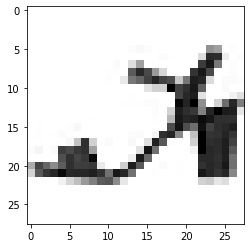

In [8]:
plt.imshow(X_train[30], cmap='binary')

Let's initialize a list of class names for MNIST (details of the dataset available via google):

In [9]:
class_names = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Boot"]

Now let's define our architecture by passing a list of layers to the Sequential model:

In [10]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

Note: the Flatten() layer computes X.reshape(-1, 28*28)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


List of layers:

In [12]:
model.layers

Let's compile our model using a multi-label loss function: 'sparse_categorical_crossentropy' (as the classes are not one-hot-encoded). We are using a Stochastic Gradient Descent  with a default learning rate lr=0.01 to optimize 'accuracy' of our model:

In [13]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [14]:
root_logdir = os.path.join(os.curdir, "logs")
run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
run_logdir = os.path.join(root_logdir, run_id)

Let's train our model on 30 epochs. We will pass the argument 'validation_data' on which Keras will measure the loss and accuracy at the end of each epoch to update all 266 610 parameters using Stochastic Gradient Descent. The default size of a batch is 32, each epoch will consists of 1719 batches of 32 examples to go through all 55000 examples every time. The model does not train on validation data but uses it to evaluate its performance and update parameters. Also, let's create a Callback that will save model checkpoints (in case of incidental interruption) and perform early stopping in case there is no more progress (after 3 epochs).

In [15]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_model.h5")
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
tensorboard_cb = keras.callbacks.TensorBoard()

In [25]:
# Load the TensorBoard extension and server on port 6006
%load_ext tensorboard
#%tensorboard --logdir=./logs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [17]:
history = model.fit(X_train, y_train, epochs=60, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/60
1719/1719 [==============================] - 5s 2ms/step - loss: 1.0055 - accuracy: 0.6818 - val_loss: 0.5061 - val_accuracy: 0.8300
Epoch 2/60
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5108 - accuracy: 0.8197 - val_loss: 0.4471 - val_accuracy: 0.8426
Epoch 3/60
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4483 - accuracy: 0.8432 - val_loss: 0.4241 - val_accuracy: 0.8528
Epoch 4/60
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4218 - accuracy: 0.8501 - val_loss: 0.3973 - val_accuracy: 0.8620
Epoch 5/60
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3998 - accuracy: 0.8596 - val_loss: 0.3916 - val_accuracy: 0.8648
Epoch 6/60
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3832 - accuracy: 0.8630 - val_loss: 0.3693 - val_accuracy: 0.8744
Epoch 7/60
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3750 - accuracy: 0.8689 - val_loss: 0.3659 - val_accuracy:

<AxesSubplot:>

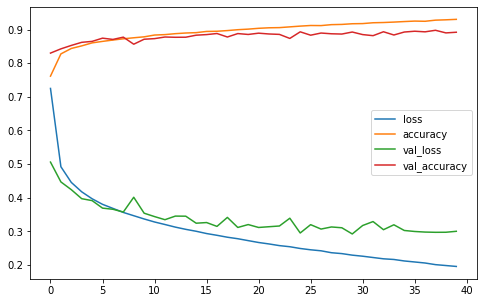

In [18]:
pd.DataFrame(history.history).plot(figsize=(8,5))

We can observe that training stopped at epoch 38/60, due to lack of progress of the val_loss metric. The training and validation metrics remain in similar performance ranges, indicating there is no overfitting and our model is acceptable.

In [19]:
# Roll back the model in case of incidental training interruption:
#model = keras.models.load_model("my_model.h5")

Let's estimate the generalization error on the test set:

In [20]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3224 - accuracy: 0.8866


[0.3223694860935211, 0.8866000175476074]

This resulat is final and gives a clear indication of performance with real-world production data.

Let's make predictions for a few instances:

In [21]:
y_pred = model.predict(X_test[:3])
y_pred = y_pred.round(2)
y_pred

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

Each instance (row) shows a series of ten probabilities for all 10 classes, the highest column being the most likely class. Now let's convert them into class names:

In [22]:
idx = np.argmax(y_pred, axis=1)
np.array(class_names)[idx]

array(['Boot', 'Pullover', 'Trouser'], dtype='<U8')

Let's compare these predictions to ground truth:

In [23]:
np.array(class_names)[y_test[:3]]

array(['Boot', 'Pullover', 'Trouser'], dtype='<U8')

Our model predicted right for these 3 instances.